In [1]:
%load_ext autoreload
%autoreload 2

# Synthetic Data

## Generate

In [2]:
from faim.data_preparation.synthetic import NormalSyntheticGroupedDatasetBuilder
import numpy as np
from numpy.random import PCG64, Generator


random_generator = Generator(PCG64(4))
group_names=["advantaged", "disadvantaged"]
synth_data_builder = NormalSyntheticGroupedDatasetBuilder(
    group_names=group_names,
    n_by_group=[50000, 50000],
    truth_prediction_means_by_group=[np.array([1, 2]), np.array([-1, -3]),],
    truth_prediction_correlation_matrixs_by_group=[
        np.array([[1, 0.8], [0.8, 1]]),
        np.array([[1, 0.8], [0.8, 1]]),
    ],
    random_generator=random_generator
)
synth_data = synth_data_builder.build()
synth_data.head()

,uuid,group,true_score,pred_score,true_label,pred_label
37946,224433929489326672739953299770889737085,0,0.897985,1.856003,1,1
4589,189184577771270294983360456394203577555,1,-0.221229,-2.008019,0,0
3166,192908752531604815820715065864066038719,0,2.361094,3.257432,1,1
17204,97825691609597283350346506381944190438,1,-0.124138,-2.095224,0,0
46899,88883320754942151413667147662500315125,1,-1.730384,-3.377135,0,0


## Data From Paper

In [3]:
!faim-experiment --prepare-data synthetic-from-paper

In [4]:
from pathlib import Path
import pandas as pd

# Load paper data (remove truncated data - it's calculated later anyways)
synth_data_from_paper_filepath = Path("prepared-data/synthetic/2groups/2022-01-12/dataset.csv")
data_from_paper = pd.read_csv(synth_data_from_paper_filepath)

## Figure 1

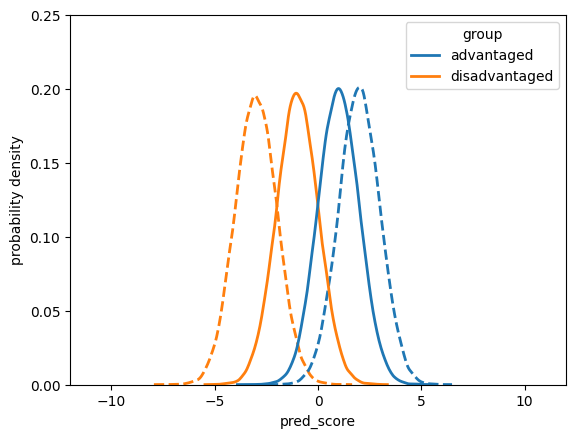

In [5]:
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("tab10")

plot_data = deepcopy(data_from_paper)
plot_data["group"] = plot_data.group.map(lambda idx: group_names[idx])

fig, ax = plt.subplots()
sns.kdeplot(data=plot_data, x="pred_score", hue="group", linestyle="--", linewidth=2, ax=ax)
sns.kdeplot(data=plot_data, x="true_score", hue="group", linestyle="-", linewidth=2, ax=ax)
_ = ax.set_ylabel("probability density")
_ = ax.set_xlim([-12, 12])
_ = ax.set_ylim([0, 0.25])

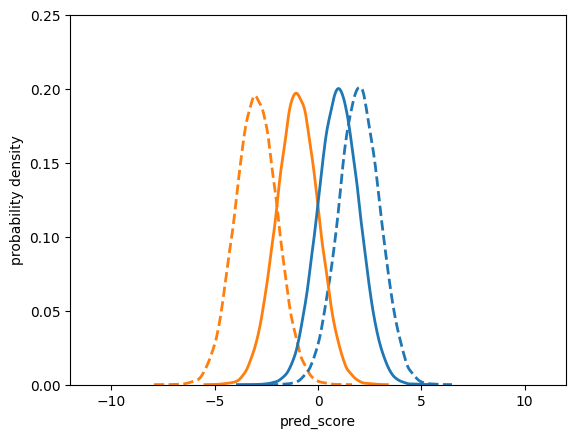

In [6]:
ax.get_legend().remove()
fig

In [7]:
fig.savefig("figures/figure1.svg", format="svg")

# FAIM Scoring

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path

group_names = {0: "advantaged", 1: "disadvantaged"}
pred_score_column = "pred_score"
score_stepsize = 0.1
thetas = {0: np.array([1, 0, 0]), 1: np.array([1, 0, 0])}
optimal_transport_regularization = 0.001
plot_dir = Path("../results/synthetic/2groups/2022-01-12-notebook/")

In [9]:
from faim.algorithm.faim import FairInterpolationMethod

fair_interpolation_method = FairInterpolationMethod(
    raw_data=data_from_paper,
    group_names=group_names,
    pred_score_column=pred_score_column,
    score_stepsize=score_stepsize,
    thetas=thetas,
    optimal_transport_regularization=optimal_transport_regularization,
    plot_dir=plot_dir,
    plot=False,
)
results = fair_interpolation_method.run()

## Label Boundary

<Axes: xlabel='pred_score_truncated'>

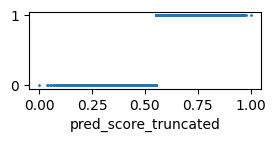

In [10]:
results.plot(x="pred_score_truncated", y="predictedLabel", style='.', markersize=2, figsize=(3, 1), legend=False)

In [11]:
def find_boundary(results) -> float:
    return (
        results[results.predictedLabel==0].pred_score_truncated.max()
        + results[results.predictedLabel==1].pred_score_truncated.min()
    ) / 2
    

In [12]:
find_boundary(results)

0.5507246376811594

## Results Figure - Calibration Condition

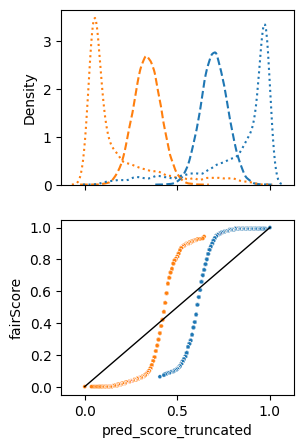

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.color_palette("tab10")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(3, 5))

sns.kdeplot(data=results, x="pred_score_truncated", hue="group", linestyle="--", ax=ax1)
sns.kdeplot(data=results, x="fairScore", hue="group", linestyle=":", ax=ax1)

sns.scatterplot(data=results, x="pred_score_truncated", y="fairScore", hue="group", s=8, ax=ax2)
plt.plot([0, 1], [0, 1], 'k-', linewidth=1)

for ax in (ax1, ax2):
    ax.get_legend().remove()

## Results Figure - All Conditions

In [15]:
thetas_by_condition = [
    {0: np.array([1, 0, 0]), 1: np.array([1, 0, 0])},
    {0: np.array([0, 1, 0]), 1: np.array([0, 1, 0])},
    {0: np.array([0, 0, 1]), 1: np.array([0, 0, 1])},
    {0: np.array([1, 1, 1]), 1: np.array([1, 1, 1])},
]
plot_dir_by_condition = [
    Path("../results/synthetic/2groups/2022-01-12-notebook/1,0,0,1,0,0/"),
    Path("../results/synthetic/2groups/2022-01-12-notebook/0,1,0,0,1,0/"),
    Path("../results/synthetic/2groups/2022-01-12-notebook/0,0,1,0,0,1/"),
    Path("../results/synthetic/2groups/2022-01-12-notebook/1,1,1,1,1,1/"),
]

results_by_condition = []
for thetas, plot_dir in zip(thetas_by_condition, plot_dir_by_condition):
    fair_interpolation_method = FairInterpolationMethod(
        raw_data=data_from_paper,
        group_names=group_names,
        pred_score_column=pred_score_column,
        score_stepsize=score_stepsize,
        thetas=thetas,
        optimal_transport_regularization=optimal_transport_regularization,
        plot_dir=plot_dir,
        plot=False,
    )
    results_by_condition.append(fair_interpolation_method.run())

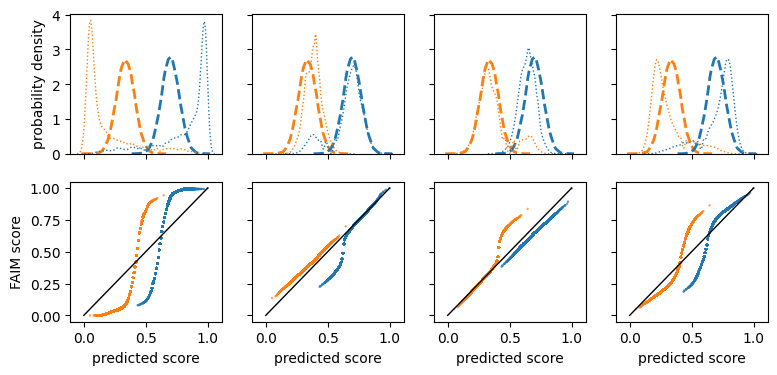

In [26]:
sns.color_palette("tab10")
fig, axes = plt.subplots(2, 4, sharex=True, sharey="row", figsize=(9, 4))

for condition_idx, results in enumerate(results_by_condition):
    ax1, ax2 = axes[:, condition_idx]

    bw_adjust=0.8
    sns.kdeplot(data=results, x="pred_score_truncated", hue="group", linestyle="--", linewidth=2, ax=ax1, bw_adjust=bw_adjust)
    # sns.histplot(data=results, x="pred_score_truncated", hue="group", ax=ax1, )
    sns.kdeplot(data=results, x="fairScore", hue="group", linestyle=":", linewidth=1, ax=ax1, bw_adjust=bw_adjust)
    # sns.histplot(data=results, x="fairScore", hue="group", ax=ax1)
    ax1.set_xlabel("score")
    ax1.set_ylabel("probability density")
    
    ax2.plot([0, 1], [0, 1], 'k-', linewidth=1)
    sns.scatterplot(
        # Take every fourth point 
        #  (huge compression for SVG without compremising interpretation, and inkscape hangs if svg too big)
        data=results.iloc[::4, :], 
        x="pred_score_truncated", y="fairScore", hue="group", s=3, ax=ax2, linewidth=0, alpha = 0.7
    )
    ax2.set_xlabel("predicted score")
    ax2.set_ylabel("FAIM score")

    for ax in (ax1, ax2):
        ax.get_legend().remove()

In [17]:
fig.savefig("figures/figure2.svg", format="svg")